The data in the form of text is being exported from the library where the articles contain the word generative AI in them. This text document exported contains the information of all the artices.
Move this data to the drive and mount the drive.

In [ ]:
#to mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#to set current working directory
%cd /content/drive/MyDrive/ProjectFinal/

/content/drive/MyDrive/ProjectFinal


Open the text file using file path, and read the text into data.

In [ ]:
file_path = "generativeai.txt"

with open(file_path, "r") as file:
    data = file.readlines()

The keywords of the articles are all placed in lines which start with the DE word. So we are supposed to take only the lines which start with a DE to consider the keywords in the Articles.

In [ ]:
de_entries = []

# Initialize variables to store the current "DE" section
current_de = ""
capture_de = False

# Loop through the lines in the file
for line in data:
    if line.startswith("DE"):
        capture_de = True
        current_de = line.strip() + " "
    elif not line.startswith("DE") and capture_de:
        de_entries.append(current_de.strip())
        capture_de = False
        current_de = ""
    elif capture_de:
        current_de += line.strip() + " "

with open("extracted_de_data.txt", "w") as outfile:
    for entry in de_entries:
      outfile.write(entry)


Import libraries that support natural language processing. Where stop-words, tokenizations and lemmatization processes are carried on.

In [ ]:
# Import necessary libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Download necessary NLTK data (if not already done)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The file that contains the previously processed DE data is read.

In [ ]:
with open("extracted_de_data.txt", "r") as file:
    data1 = file.read()
data1

'DE HCI; AI; Generative AI; Human-AI InteractionDE Generative AI; Design; Bias; UncertaintyDE Legal; Law; Explainable AI; Blockchain; Generative AI; Responsible AIDE arguments; creativity; generative AI; universal audienceDE AI governance; AI regulation; generative AI; generative models;DE Generative AI; Art; Artificial intelligence; Machine learning;DE forensic psychiatry; forensic AI; generative AI; generative artificialDE Speculative Design; Generative AI; Creativity; Embodiment; FuturesDE Large Language Models; LLM; GPT-3; GPT-4; ChatGPT; generative AI; textDE Generative AI; innovation diffusion; TOE frameworkDE Generative AI; Telecom; 6 G; 5 G; Survey; ApplicationDE Generative AI; Large language models; Generative adversarial networks;DE Self-Healing Systems; Generative AI; Anomaly Detection; Code GenerationDE Software development; Generative AI; Real-time digital economyDE UTAUT; Generative AI; AI anxiety; creative professionalsDE Generative AI; ChatGPT; Pedagogical agents; Socra

Unwanted words are excluded, tokenization of the text is carried on, stop words are removed and words that tend to have the same meaning are considered as equivalent. The words which need to be excluded can be put up in the exclusion list.

In [ ]:
import spacy
from collections import Counter

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")


# Tokenization
doc = nlp(data1)
tokens = [token.text for token in doc]

# Exclusion list (add any words you want to exclude)
exclusion_list = ["de", ";", "-","DE","'","(",")"]

# Filter out stop words and excluded words
filtered_tokens = [word for word in tokens if not nlp.vocab[word].is_stop and word.lower() not in exclusion_list]

# Lemmatization
lemmatized_tokens = [token.lemma_ for token in doc if token.text in filtered_tokens]

# Create a mapping to treat equivalent words
equivalent_words = {"generative":"Generative","ai":"AI"}

# Replace lemmatized tokens based on the mapping
final_tokens = [equivalent_words.get(token, token) for token in lemmatized_tokens]

# Calculate frequency distribution
freq_dist = Counter(final_tokens)

# Convert frequency distribution to a DataFrame
df = pd.DataFrame(freq_dist.most_common(), columns=['Word', 'Frequency'])

# Display the DataFrame
df


,Word,Frequency
0,AI,67
1,Generative,53
2,AIDE,6
3,ChatGPT,6
4,artificial,5
...,...,...
200,interaction,1
201,anthropomorphism,1
202,HumanoidDE,1
203,intelligence;de,1


In [ ]:
pip install nltk networkx matplotlib

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


A weighted co-occurance graph explains the relation between the adjacent words in a particular context. In the graph below the nodes represent the words and the edges represent the occurances between the words. The weight of the edge indicates the strength of the co-occurance. The tokens are considered to get the co-occurance pairs.

In [ ]:
# Create co-occurrence pairs with weights
co_occurrence_pairs = [(final_tokens[i],
final_tokens[j]) for i in range(len(final_tokens))
for j in range(i + 1, len(final_tokens))]
weighted_co_occurrences = nltk.FreqDist(co_occurrence_pairs)

In [ ]:
# Build the weighted co-occurrence network
G = nx.Graph()
for (word1, word2), weight in weighted_co_occurrences.items():
  G.add_edge(word1, word2, weight=weight)

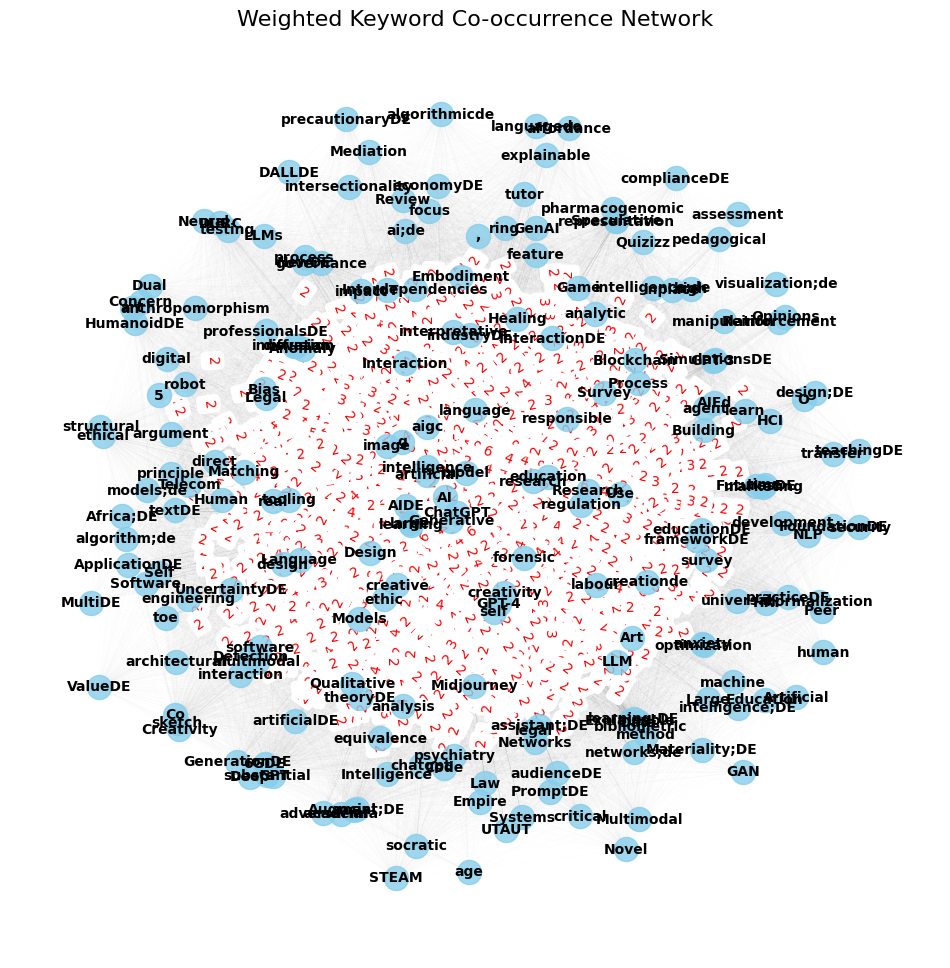

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
edge_weights_normalized = [weight / max(edge_weights) * 5 for weight in edge_weights]

nx.draw_networkx_nodes(G, pos, node_size=300,node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray',width=edge_weights_normalized, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10,font_color='black', font_weight='bold')

edge_labels = {(word1, word2): f'{weight}' for (word1,word2, weight) in G.edges(data='weight') if weight > 1}
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels, font_color='red')
plt.title("Weighted Keyword Co-occurrence Network",fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
node_degrees = {node: G.degree(node) for node in G.nodes()}
node_degrees_sorted = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

node_degrees_sorted

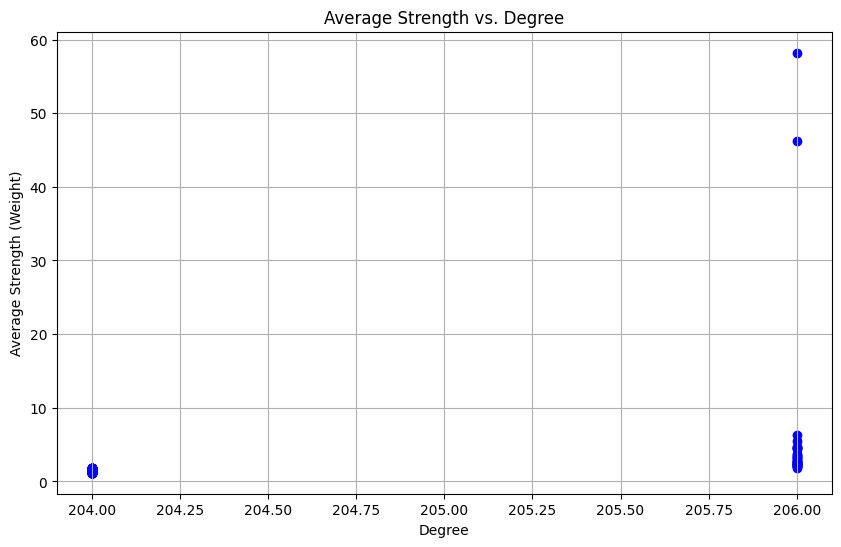

In [ ]:
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

The words with higher strength are treated to be more important and give an idea about the key concepts of the corpus. Therefore the words such as generative, AI, ChatGPT etc give us the major understanding regarding the corpus.

In [ ]:
# Calculate node strength (sum of weights of edges connected to the node)
node_strengths = {node: sum(G[node][neighbor]['weight'] for neighbor in G[node]) for node in G.nodes()}

# Convert node strengths to a sorted list for display
node_strengths_sorted = sorted(node_strengths.items(), key=lambda x: x[1], reverse=True)

# Displaying as a DataFrame
pd.DataFrame(node_strengths_sorted, columns=['Node', 'Strength'])

,Node,Strength
0,AI,11991
1,Generative,9520
2,AIDE,1295
3,ChatGPT,1121
4,model,953
...,...,...
200,human,242
201,robot,242
202,interaction,242
203,anthropomorphism,242


The words in the co-occurance networks that are appearing together tend to share similar contextual meanings. The words such as software, industry, maketing,artificial,building etc gives an insight that they are referred to tegether and may occur together more often.
Through this analysis we can conclude that the corpus downloaded that contained the articles in the year of 2023 majorly focus on the generative AI concept and especially it's focus and importance in the ChatGPT. Therefore it shows the dominance and importance of discussion regarding the conversational and chatbot AI's